## FDL-Assignment
### Please fill the blanks in the code and answer to the questions that are asked. Send your solution to maria.vakalopoulou@centralesupelec.fr by 15 / 01 / 2021. 
### Instructions: Rename the jupyter adding your name at the end of the title and as subject for the mail please put FDL-Assignment-<YOUR NAME\>

### Question 1 -  TRAIN ON CIFAR DATASET
In this exercise you are asked to train a Convolutional Neural Network (CNN) on the CIFAR10 dataset and visualize its feature maps.

2a) Download the CIFAR10 dataset using the already provided PyTorch dataloaders. 
*   Read and understand the following code
*   Feel free to add additional transformations for data augmentation

In [1]:
import os
import glob
from google.colab import drive

## load train, test and validation label arrays
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Download the CIFAR10 dataset using the PyTorch dataloaders
import torch
import torchvision
import torchvision.transforms as transforms

# *****START CODE 
## Data
##Here you are free to add further transform functions if you wish
print('==> Preparing data..')

'''first() for mean,second() for standard deviation'''

transform_train = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))#recommended mean and standard deviation for data normalization
])

transform_test = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
#CIFAR10 are 60K 32*32 images(RGB 255)
#torchvision is for data-collected;dataloader can be self-defined & auto-batch
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64 , shuffle=True)

#define also test-set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
val_dataloader = torch.utils.data.DataLoader(testset, batch_size=64 , shuffle=False)
# *****END CODE

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


1b) Create your convolutional neural network.
*   Create your own CNN architecture, defining the modules that you want to include
*   Be sure you are using convolutional modules, activation functions as well as fully connected modules
*   Use different modules and hyperparameters to boost the performance of the network

**For this part, I firstly defined a traditional model Lenet-5[in class:Convnet] and then,defined a structure of model ResNet(16;34etc)[in class:ResNet]**

In [4]:
import torch.nn as nn
import torch.nn.functional as F
#traditional model:Lenet-5
# *****START CODE
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)#now the output size=5*5*channel putput(16)flatten and full-connected
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        
        
        
    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x))) #processing in layer1
      x = self.pool(F.relu(self.conv2(x)))   #layer2
      x = torch.flatten(x,1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x) 
      return x

    


# *****END CODE

In [6]:
#ResNet
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channel, out_channel, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channel)
    self.downsample = downsample # in case intermediate layer does not match the channel size

  def forward(self, x): #forward of one basic block 
    identity = x #original activation input for basic block
    if self.downsample is not None: # which means channel size in block doesn't match:we need downsample x by adding new layers for x
      identity = self.downsample(x)

    out = self.relu(self.bn1(self.conv1(x)))

    out = self.bn2(self.conv2(out))

    out += identity
    out = self.relu(out) #as relu is after the PLUS action.

    return out

class Bottleneck(nn.Module):
  expansion = 4 

  def __init__(self, in_channel, out_channel, stride=1, downsample=None):#out_channel is not the final out,is the outsize of the first layer
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, 1, stride=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.conv2 = nn.Conv2d(out_channel, out_channel, 3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channel)
    self.conv3 = nn.Conv2d(out_channel, out_channel*self.expansion, 1, stride=1, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x): #forward of one basic block 
    identity = x #original activation input for basic block
    if self.downsample is not None: # which means channel size in block doesn't match:we need downsample x by adding new layers for x
      identity = self.downsample(x)

    out = self.relu(self.bn1(self.conv1(x)))

    out = self.relu(self.bn2(self.conv2(out)))

    out = self.bn3(self.conv3(out))
    out += identity
    out = self.relu(out) #as relu is after the PLUS action.

    return out

class ResNet(nn.Module):
  def __init__(self, block, blocks_num, num_classes=10, include_top=True): 
    # block is in [basicblock ,bottleneck];
    # blocks_num is [2,2,2,2] for 18-layer; [3,4,6,3]for 34-layer;
    super(ResNet, self).__init__()
    self.include_top = include_top
    self.in_channel = 64

    self.conv1 = nn.Conv2d(3, self.in_channel, 7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(self.in_channel)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, blocks_num[0]) #数字是：#input channels
    self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2 since we need to make h&w=output
    self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
    self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)

    if self.include_top:
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.fc = nn.Linear(512*block.expansion, num_classes) #output
    
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
  
  def _make_layer(self, block, channel, block_num, stride=1):
    downsample = None
    if stride !=1 or self.in_channel != channel* block.expansion: #not useful for 18&34,useful for layer-50-152 ,when layer size !=64
      downsample = nn.Sequential(
          nn.Conv2d(self.in_channel, channel*block.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(channel*block.expansion))
    layers = []
    layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride)) #here we use what we defined for block
    #if downsample=none, then it was just a block without conv for x.
    self.in_channel = channel*block.expansion

    for _ in range(1, block_num): #block_num:[3,4,6，3] for resnet-34
      layers.append(block(self.in_channel, channel)) #这个再看看：由于从第二个循环开始，比如for 50-layer， channel数和 x的channel数相同，所以用不到downsample了。

    return nn.Sequential(*layers)

  def forward(self, x):
    x=self.maxpool(self.relu(self.bn1(self.conv1(x))))

    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)

    if self.include_top:
      x = self.avgpool(x)
      x = torch.flatten(x,1)
      x = self.fc(x)
    return x

def resnet34(num_classes=10, include_top=True):
  return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes, include_top=True)

def resnet101(num_classes=10, include_top=True):
  return ResNet(Bottleneck, [3,4,23,3], num_classes=num_classes, include_top=True)



1c) Create the training scheme
*    Call the model
*    Specify the training hyperparameters like type of optimizer and criterion
*    Specify number of epochs

**Here we firstly make convnet object and train our model.**

In [ ]:
# *****START CODE
'''（1）iteration：表示1次迭代（也叫training step），每次迭代更新1次网络结构的参数；
（2）batch-size：1次迭代所使用的样本量；
（3）epoch：1个epoch表示过了1遍训练集中的所有样本。
值得注意的是，在深度学习领域中，常用带mini-batch的随机梯度下降算法（Stochastic Gradient Descent, SGD）训练深层结构，它有一个好处就是并不需要遍历全部的样本，
当数据量非常大时十分有效。此时，可根据实际问题来定义epoch，例如定义10000次迭代为1个epoch，若每次迭代的batch-size设为256，那么1个epoch相当于过了2560000个训练样本。
'''
model1 = ConvNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
epochs = 6
# *****END CODE

**Here I created a folder for convnet.**

In [ ]:
save_folder = 'drive/My Drive/DL_20_21/ConvNet/models'
def write_results(ff, save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    ff=open('{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_OA: ')
    ff.write(str('%.3f' % train_acc))
    ff.write(' VAL_OA: ')
    ff.write(str('%.3f' % val_acc))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

**And then,I made resnet34 object and reran the for-loop for training model.**

In [18]:
model = resnet34()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
epochs = 6

**Here,I created a folder for Resnet.**

In [19]:
save_folder = 'drive/My Drive/DL_20_21/ResNet/models'
def write_results(ff, save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    ff=open('{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_OA: ')
    ff.write(str('%.3f' % train_acc))
    ff.write(' VAL_OA: ')
    ff.write(str('%.3f' % val_acc))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

In [20]:
!pip install torchnet
import torchnet as tnt

# define confusion matrix using tnt package
confusion_matrix = tnt.meter.ConfusionMeter(10)

**Here I define the graph of loss .**

In [21]:
import matplotlib.pyplot as plt
# create a function that creates train-val loss graph and saves the figure in a destination folder
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

1d) Plot the train and validation loss curves for the entire training process
*   Validate the model after each epoch
*   Plot both training and validation loss curves
*   Write a small description discussing about the curves. What is the behaviour of the model?

**For this part ,i just re-used it for model1[Lenet-5] and model2[Resnet-34] since all the code are almost the same.**

---

---




**The performance of Resnet is better than lenet-5,so here the result shown below is that of resnet-34.**

Train (epoch 0/6) [0/782 (0%)]	Loss: 2.794237
Train (epoch 0/6) [100/782 (13%)]	Loss: 1.902273
Train (epoch 0/6) [200/782 (26%)]	Loss: 2.020070
Train (epoch 0/6) [300/782 (38%)]	Loss: 1.726080
Train (epoch 0/6) [400/782 (51%)]	Loss: 2.101379
Train (epoch 0/6) [500/782 (64%)]	Loss: 1.482859
Train (epoch 0/6) [600/782 (77%)]	Loss: 1.662562
Train (epoch 0/6) [700/782 (90%)]	Loss: 1.643329
Confusion Matrix:
[[433 102 104  15  23  31  14  20 243  15]
 [ 33 706  28  17  17  12  11  11 126  39]
 [ 63  50 501  30  94 132  33  45  45   7]
 [ 20  90 199 165  82 345  24  26  39  10]
 [ 26  48 286  31 299 152  27  96  34   1]
 [  7  69 188  50  37 560  13  34  40   2]
 [  5  79 163 104 130 109 365  14  25   6]
 [ 19  90  97  37  54 245   6 416  16  20]
 [ 89 155  22  13   7  16   4  12 651  31]
 [ 21 428  37  41  12  24  10  22 123 282]]
TRAIN_LOSS:  1.807 TRAIN_ACC:  38.756
VAL_LOSS:  5.272 VAL_ACC:  43.780
Train (epoch 1/6) [0/782 (0%)]	Loss: 1.530802
Train (epoch 1/6) [100/782 (13%)]	Loss: 1.97

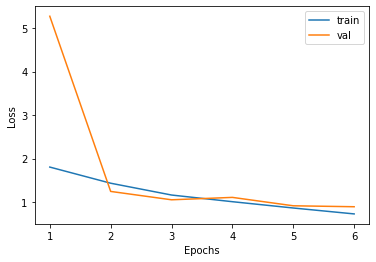

In [22]:
## Train the model and validate it after each epoch.
## Provide the train-val loss graph.
import numpy as np

total_train_losses = []
total_val_losses = []

ff=open('{}/progress.txt'.format(save_folder),'w')
# *****START CODE
for epoch in range(epochs): # loop over the dataset multiple times
    model.train()
    train_losses = []
    confusion_matrix.reset()
    for i, data in enumerate(train_dataloader): # i_final=5000=50000/batchsize
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()        
        optimizer.step()

     
        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), labels.long())
        # print statistics
        if i % 100 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))

    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    confusion_matrix.reset()

     ##VALIDATION##
    model.eval()
    val_losses = []

    for i, data in enumerate(val_dataloader):
        inputs, labels = data
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        val_losses.append(loss.item())

        confusion_matrix.add(outputs.data.squeeze(), labels)
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)

    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()
    write_results(ff, save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

save_graph(total_train_losses, total_val_losses, epochs, save_folder)



# *****END CODE

**This is the graph of training process for resnet-34.**

**Comment for the curve graph:**

---


We see that the traning loss curve decreases continuouly as the network studies more and more with the train set.However, the validation loss curve decreases at first, but seems to be slightly changed at the last epochs.
Maybe the network will perform better after epoch-6,but since the learning rate is very small,the training time is so long,so I just make epoch=6.

---



1e) Pick an intermediate layer from your convolutional neural network and visualize what patterns the network has learned
*   Complete the following code that visualizes the patterns of the network
*   Write a small description commenting on the visualized maps. What do you observe in the different visualizations of the feature maps?

**For 1-e,I just use the middle process of convnet & choose the maps just after second convolution step.**

Filter 0. Epoch 30. Loss = -36582.9531
Filter 1. Epoch 30. Loss = -37594.7461
Filter 2. Epoch 30. Loss = -37133.1406
Filter 3. Epoch 30. Loss = -37117.5781
Filter 4. Epoch 30. Loss = -37751.9922
Filter 5. Epoch 30. Loss = -38274.9375
Filter 6. Epoch 30. Loss = -36529.1094
Filter 7. Epoch 30. Loss = -36651.0078
Filter 8. Epoch 30. Loss = -36537.6172
Filter 9. Epoch 30. Loss = -36987.5781
Filter 10. Epoch 30. Loss = -36825.5312
Filter 11. Epoch 30. Loss = -36634.0312
Filter 12. Epoch 30. Loss = -36811.0430
Filter 13. Epoch 30. Loss = -36487.7734
Filter 14. Epoch 30. Loss = -36502.3281
Filter 15. Epoch 30. Loss = -37388.7969


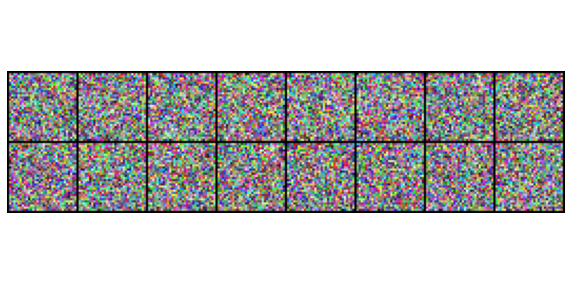

In [ ]:
import sys
from skimage import io
import torchvision.utils as vutils
'''In the step 1-e,we tried to find the image(input) which give us the maximum output activations. '''
##function for printing the loss during optimization
def write_flush(text, stream=sys.stdout):
    stream.write(text)
    stream.flush()
    return

## Number of feature maps in the intermediate layer that you have chosen. 
# *****START CODE
n_conv = 16  # e.g 64:某个layer中的activation function搞完之后的neuron个数（也就是能出来32张2D的feature图）。
# *****END CODE

## Size of visualised filter.
img_size = 32 #initial image size

##load your optimal model
# *****START CODE
model = ConvNet()
model.load_state_dict(torch.load('drive/My Drive/DL_20_21/ConvNet/models/model_5.pt')) 
# *****END CODE

## Create a submodel, until the intermediate layer of your choice.
## Hint: Use model.#name# to create the succession of layers, where #name#
## stands for the layer names that you defined in the initialization function 
## of your model.
# *****START CODE
#choose the maps after the second convolution.
submodel = nn.Sequential(
    model.conv1,
    model.pool,
    model.conv2
)
# *****END CODE

## Put submodel in eval mode.
submodel.eval()

## Tensor to visualised filters. 
img_stack = torch.zeros((n_conv, 3, img_size, img_size))

## Number of epochs to run for every filter. 
# *****START CODE
n_epochs_per_filt =  30 #e.g 30
# *****END CODE

## Visualise every convolution. 
for c in range(n_conv):
    ## Initialise with random image. 
    img = torch.rand(1, 3, img_size, img_size).float()

    ## Turn on gradient calculation on the image
    # *****START CODE
    img.requires_grad_(True)

    # *****END CODE
    

    ## Define optimizer.
    # *****START CODE
    optimizer = torch.optim.Adam([img], lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    # *****END CODE
    
    for f in range(n_epochs_per_filt):
        optimizer.zero_grad()

        ## Feedforward propagation
        ## Hint: In order to find the loss, compute the negative of the activation of the hidden layer. 
        ## The objective is to produce an input image which maximizes the activation 
        ## of neurons in a particular hidden layer. 
        # *****START CODE
        output = submodel(img)
       
        loss = - torch.sum(torch.abs(output[0,15]))
        loss.backward()        
        optimizer.step()
        
        
        # *****END CODE
        write_flush('\rFilter %d. Epoch %d. Loss = %.4f'%(c, f+1, loss.item()))

    write_flush('\n')
    img_stack[c, :, :, :] = img[0].detach() #16 images sent to img_stack

## Make grid out of visualized filters. 
##Here you may have to adjust the properties of vutils.make_grid, depending on your needs. 
##For example, you may need to change the number of rows.
G = vutils.make_grid(img_stack, nrow=8, normalize=True, padding=1).permute(1,2,0).numpy()
plt.figure(figsize=(10,5))
plt.imshow(G)
plt.axis('equal')
plt.axis('off')
plt.show()

**Comment:They are just making up by some different colors of point,not so many rules can be concluded by these 16 filters in this step.**

### Question 2 - Train on geometrical shapes

Function 'generate_a_triangle' produces images depicting random triangles along with the (x,y) coordinates of the vertices. Create a convolutional neural network that receives as input the triangle image and predicts the corresponding (x,y) coordinates of the triangle's vertices. 
*  Read and understand the following code

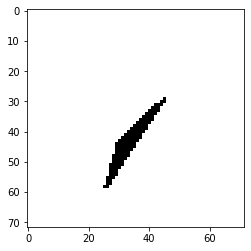

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_triangle():
    figsize = 1.0
    U = np.random.random(3)
    V = np.random.random(3)
    imdata = generate_a_drawing(figsize, U, V)# imdata是画好的三角形
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]# return的首先是图像的RGB码，然后是三角形对应的坐标;[x1,y1,x2,y2,x3,y3]。

[im, v] = generate_a_triangle()#im是图像；v是坐标
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

def generate_dataset_regression(nb_samples):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 1000 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle() #X,Y 行对应的是each sample
    X = X / 255
    return [X, Y] #

import matplotlib.patches as patches

def visualize_prediction(x, y):#这里的x应该指的是一个sample 的 二维 code。
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)#一行对应三角形一个角的坐标
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)#貌似是把图形加边
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
 # '''generating images with corresponding axis and returned;used for test.'''
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300)
    return [X_test, Y_test]

2a) Use function 'generate_dataset_regression' to create the dataset. Split the dataset to training and validation parts.

In [24]:
##generate dataset
# *****START CODE
np.random.seed(2021)
[X, Y]= generate_dataset_regression(10000)

# *****END CODE

Creating data:
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


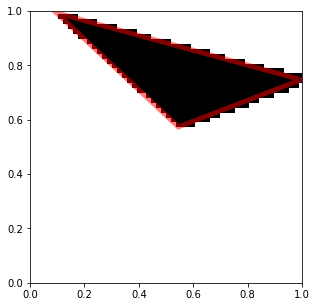

In [25]:
visualize_prediction(X[1], Y[1]) 
#red line is made by add_patch

In [26]:
##split the dataset to training and validation parts
# *****START CODE
p=0.8 #proportion of tset size
M=X.shape[0] #total size of image generated

[X_train, Y_train]=[X[0:int(p*M),:],Y[0:int(p*M),:]]
[X_val, Y_val]=[X[int(p*M):,:],Y[int(p*M):,:]]

X_train= X_train.reshape(int(p*M),1,72,72) #since data generated are flatten,we use reshape to construct image form data.
X_val=X_val.reshape(X_val.shape[0],1,72,72)

X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_val = torch.tensor(X_val)
Y_val = torch.tensor(Y_val)
# *****END CODE

In [ ]:
'''import pandas as pd
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
class MyDataset(Dataset):
    def __init__(self,X,Y):
        self.images = torch.Tensor(X) #rgb code
        self.data_info = pd.DataFrame(Y)


    def __getitem__(self, idx):
        image_id = int(self.data_info.iloc[idx,0])
        image = self.images[image_id]

        label = torch.Tensor(self.data_info.iloc[image_id])
        return image,label
    
    def __len__(self):
        return len(self.data_info)

train_data = MyDataset(X_train,Y_train)
print(train_data[1])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True )'''

In [ ]:
batchsize = 10 #自定义dataset seems not to work,
# *****START CODE
train_image=np.zeros((800,10,1,72,72))
train_label=np.zeros((800,10,6))
for i in range(0, len(X_train), batchsize):
    img_batch = np.array(X_train[i:i+batchsize])
    lbl_batch = np.array(Y_train[i:i+batchsize])
    j=int(i/10)
    train_image[j]=img_batch
    train_label[j]=lbl_batch
   # print(i)
   # print('img_batch', img_batch.shape)
   # print('lbl_batch', lbl_batch.shape)

train_image = torch.Tensor(np.array(train_image))
train_label = torch.Tensor(np.array(train_label))



2b) Use function 'generate_test_set' to create the testing dataset.

In [ ]:
##generate test dataset
# *****START CODE
[X_test, Y_test]=generate_test_set_regression()
X_test= X_test.reshape(X_test.shape[0],1,72,72)
# *****END CODE

In [43]:
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

2c) Create your convolutional neural network.
* Similarly to the previous exercise construct your network and choose your modules
* Optimize the architecture to perform well on predicting the different coordinates

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# *****START CODE
class ConvNetR(nn.Module):
    def __init__(self):
        super(ConvNetR, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear(5184, 1024),
            nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU())
        self.rfc = nn.Sequential(
            nn.Linear(1024, 6),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.rfc(out)
        return out
    


# *****END CODE

In [44]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channel, out_channel, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channel)
    self.downsample = downsample # in case intermediate layer does not match the channel size

  def forward(self, x): #forward of one basic block 
    identity = x #original activation input for basic block
    if self.downsample is not None: # which means channel size in block doesn't match:we need downsample x by adding new layers for x
      identity = self.downsample(x)

    out = self.relu(self.bn1(self.conv1(x)))

    out = self.bn2(self.conv2(out))

    out += identity
    out = self.relu(out) #as relu is after the PLUS action.

    return out

class Bottleneck(nn.Module):
  expansion = 4 

  def __init__(self, in_channel, out_channel, stride=1, downsample=None):#out_channel is not the final out,is the outsize of the first layer
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, 1, stride=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.conv2 = nn.Conv2d(out_channel, out_channel, 3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channel)
    self.conv3 = nn.Conv2d(out_channel, out_channel*self.expansion, 1, stride=1, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x): #forward of one basic block 
    identity = x #original activation input for basic block
    if self.downsample is not None: # which means channel size in block doesn't match:we need downsample x by adding new layers for x
      identity = self.downsample(x)

    out = self.relu(self.bn1(self.conv1(x)))

    out = self.relu(self.bn2(self.conv2(out)))

    out = self.bn3(self.conv3(out))
    out += identity
    out = self.relu(out) #as relu is after the PLUS action.

    return out

class ResNet(nn.Module):
  def __init__(self, block, blocks_num, num_classes=10, include_top=True): 
    # block is in [basicblock ,bottleneck];
    # blocks_num is [2,2,2,2] for 18-layer; [3,4,6,3]for 34-layer;
    super(ResNet, self).__init__()
    self.include_top = include_top
    self.in_channel = 64

    self.conv1 = nn.Conv2d(1, self.in_channel, 7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(self.in_channel)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, blocks_num[0]) #数字是：#input channels
    self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2 since we need to make h&w=output
    self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
    self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)

    if self.include_top:
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.fc = nn.Linear(512*block.expansion, num_classes) #output
    
    for m in self.modules():#这里没写完
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
  
  def _make_layer(self, block, channel, block_num, stride=1):
    downsample = None
    if stride !=1 or self.in_channel != channel* block.expansion: #not useful for 18&34,useful for layer-50-152 ,when layer size !=64
      downsample = nn.Sequential(
          nn.Conv2d(self.in_channel, channel*block.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(channel*block.expansion))
    layers = []
    layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride)) #here we use what we defined for block
    #if downsample=none, then it was just a block without conv for x.
    self.in_channel = channel*block.expansion

    for _ in range(1, block_num): #block_num:指的是3,4,6，3 中的数字
      layers.append(block(self.in_channel, channel)) #这个再看看：由于从第二个循环开始，比如for 50-layer， channel数和 x的channel数相同，所以用不到downsample了。

    return nn.Sequential(*layers)

  def forward(self, x):
    x=self.maxpool(self.relu(self.bn1(self.conv1(x))))

    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)

    if self.include_top:
      x = self.avgpool(x)
      x = torch.flatten(x,1)
      x = self.fc(x)
    return x

def resnet34(num_classes=6, include_top=True):
  return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes, include_top=True)

def resnet101(num_classes=6, include_top=True):
  return ResNet(Bottleneck, [3,4,23,3], num_classes=num_classes, include_top=True)

def resnet16(num_classes=6, include_top=True):
  return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes, include_top=True)


2d) Define model, optimizer, criterion and number of epochs.

In [ ]:
# *****START CODE
'''model = ConvNetR()
optimizer =  torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.PoissonNLLLoss()
epochs = 10'''
# *****END CODE

**Version1: with batch and SDG.**

In [50]:
model=resnet34()
optimizer =  torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 3

**Version2: Do Gradient descent for all samples.**

2e) What criterion did you choose and why?
* Write a small description for the loss function that you want to use for this specific problem.
* What was your intuition for using this loss?

**Description**:It is just the (1/sample_size)*sum of square of all the difference between the real output and generetated output.

---


**Intuition**: Here I use MSELoss since there are two points which differ from the previous exercise:

1.   the output are multiple:
  

> for the previous exercise,the output can be 10 different types,but one sample(image) can have just one output(ex: it cannot be cat and dog)


> but for this question,we will have one image==>6 outputs




2.   the output is not 0/1(yes/no) anymore,it is of type float now. So regression with no relu/other activation in the last step.

So MSELoss define better the loss for the output of type float/int than CrossEntropyLoss.





2f) Train your model and validate it at the end of each epoch.
* Similarly to the previous question train and validate your network for each epoch
* Write a small description on how you decide which is the optimal epoch
* Use this epoch and evaluate your model on the test set
* Visualise some predictions using the function 'visualize_prediction'
* What do you observe?

**Version1 for training:using batch**

In [51]:
save_folder = 'drive/My Drive/DL_20_21/Triangle/models/'

In [47]:
def write_results(save_folder, epoch, train_loss, val_loss):
    ff=open('./{}/progress_v6.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

In [52]:
# *****START CODE
total_train_losses = []
total_val_losses = []

ff=open('./{}/progress_v6.txt'.format(save_folder),'w')

for epoch in range(1,epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []
   
    for i in range(train_image.shape[0]):
        img_batch = train_image[i]
        lbl_batch = train_label[i]

        ##implement the forward and backward backpropagation
        # *****START CODE
        optimizer.zero_grad()
        output = model(img_batch.float())
        loss=criterion(output, lbl_batch.float())
        #as we have value type output:no longer using dtype=long
        loss.backward()
        optimizer.step()
        # *****END CODE

        train_losses.append(loss.item())
        
        if i % 100 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_image),100.*i/len(train_image), loss.item()))

    
    train_loss_mean = np.mean(train_losses)
    
     ##VALIDATION##
    model.eval()
    val_losses = []

    
    outputs=model(img_batch.float())
    loss=criterion(outputs, lbl_batch.float())
        # *****END CODE

    #confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
    val_losses.append(loss.item())

    val_loss_mean = np.mean(val_losses)
    

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean)

    write_results(save_folder, epoch, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + 'model_{}.pt'.format(epoch))





# *****END CODE

Train (epoch 1/3) [0/240 (0%)]	Loss: 0.305790
Train (epoch 1/3) [100/240 (42%)]	Loss: 0.093092
Train (epoch 1/3) [200/240 (83%)]	Loss: 0.082928
Train (epoch 1/3) [300/240 (125%)]	Loss: 0.090740
Train (epoch 1/3) [400/240 (167%)]	Loss: 0.103974
Train (epoch 1/3) [500/240 (208%)]	Loss: 0.092176
Train (epoch 1/3) [600/240 (250%)]	Loss: 0.076093
Train (epoch 1/3) [700/240 (292%)]	Loss: 0.079148
TRAIN_LOSS:  0.097
VAL_LOSS:  0.091
Train (epoch 2/3) [0/240 (0%)]	Loss: 0.101003
Train (epoch 2/3) [100/240 (42%)]	Loss: 0.077395
Train (epoch 2/3) [200/240 (83%)]	Loss: 0.082986
Train (epoch 2/3) [300/240 (125%)]	Loss: 0.077196
Train (epoch 2/3) [400/240 (167%)]	Loss: 0.092246
Train (epoch 2/3) [500/240 (208%)]	Loss: 0.076004
Train (epoch 2/3) [600/240 (250%)]	Loss: 0.075893
Train (epoch 2/3) [700/240 (292%)]	Loss: 0.093861
TRAIN_LOSS:  0.084
VAL_LOSS:  0.062
Train (epoch 3/3) [0/240 (0%)]	Loss: 0.071880
Train (epoch 3/3) [100/240 (42%)]	Loss: 0.061871
Train (epoch 3/3) [200/240 (83%)]	Loss: 0.069

**Version2 for training:NOT DO BATCHING:WHEN THE SAMPLES ARE NOT LARGE.**

In [ ]:
'''model2=ConvNetR()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.01)#here we change to ADAM as we change to the whole dataset training.
criterion = nn.MSELoss()
epochs = 5'''

In [ ]:
'''ff=open('./{}/progress_v6.txt'.format(save_folder),'w')

##TRAINING##
model2.train()
train_losses = 0

img_batch = X_train
lbl_batch = Y_train

optimizer.zero_grad()
output = model2(img_batch.float())
loss=criterion(output, lbl_batch.float())
        
loss.backward()
optimizer.step()

train_losses=loss.item()

model.eval()
val_losses = 0

    
outputs=model2(img_batch.float())
loss=criterion(outputs, lbl_batch.float())
val_losses=loss.item()

    
    

print('TRAIN_LOSS: ', '%.3f' % train_loss_mean)
print('VAL_LOSS: ', '%.3f' % val_loss_mean)

write_results(save_folder, epoch, train_loss_mean, val_loss_mean)

torch.save(model.state_dict(), save_folder + 'model_{}.pt'.format(epoch))'''




**Prediction Part**


---

Here I use model_3 of version 1[do batch]since it has the best performance in terms of:


1.   train loss
2.   validation loss



In [53]:
model = resnet34()
model.load_state_dict(torch.load('drive/My Drive/DL_20_21/Triangle/models/model_3.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 

In [54]:
answer_list=[]
for i in range(len(X_test)):
  
  img=X_test[i]
  #label=torch.tensor(Y_test[i])
  img = img/255.0 #normalization
  img = np.expand_dims(img,0)
  img = np.array(img, dtype='float32')
  img = torch.from_numpy(img)
  output=model(img)
  answer_list.append(output.detach().numpy().squeeze())
  

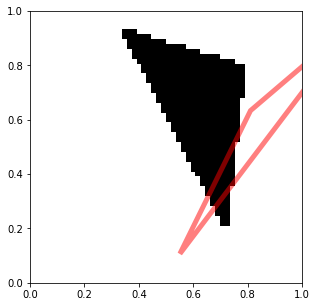

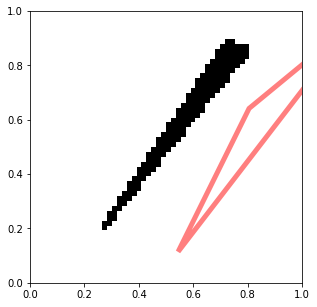

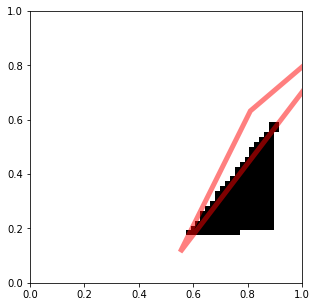

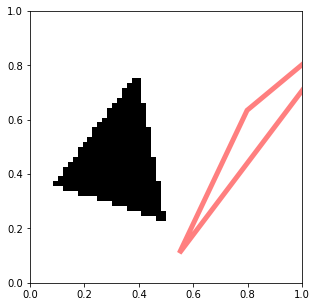

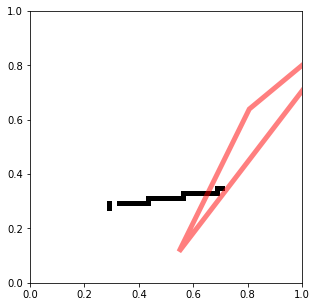

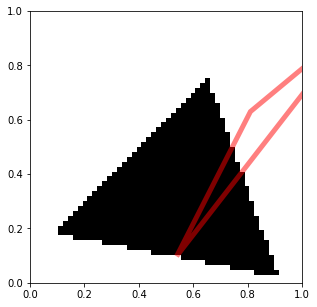

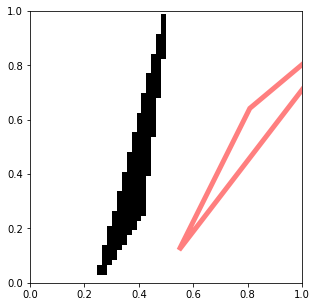

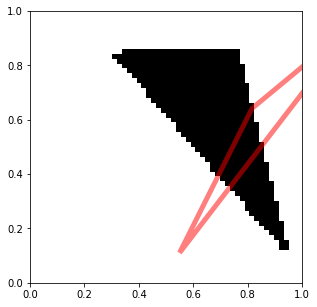

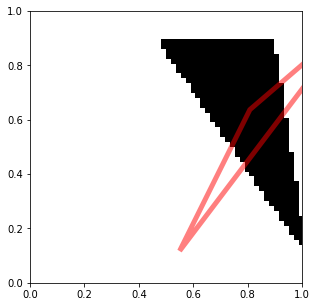

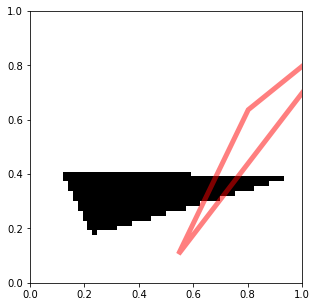

In [55]:
for i in range(10):
  visualize_prediction(X_test[i],answer_list[i])

**My observation:**

> The prediction version of output seems not to perform very well in this case.


1.   The generated output seems to be unchanged
2.   The scale of generated output seems to be smaller than the original one.



---












2g) Think and implement a preprocessing step that can boost the accuracy of your network

I was thinking about 2 reasons maybe related to the bad performance.

1.   data normalization:
In the previous data-preprocessing process,we just simply divided by 255.We can try to do some other normalization method for this special problem.

2.   loss function :
When we simply do the element-wise MSEloss for 6 outputs, in fact, we gave the same weight between these 6 output.However, the relation between x and y of 1 given point seems to be more important than the relation between each point[(x1,y1) and (x2,y2)].So if we can find a new form of loss function which give more weight to (x,y) in one point and less weight to [(x1,y1) and (x2,y2)],maybe that would be better.

In [ ]:
# *****START CODE

#If Mydataset could work,then we can do normalization with 'transforms.Normalize'
transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.2)), # Normalization
])

transform_label = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.2)), # Normalization
])

# *****END CODE